In [1]:
import numpy as np
import pandas as pd

#import pystan
from sklearn.model_selection import train_test_split
import pickle
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from argparse import ArgumentParser, ArgumentTypeError
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df = pd.read_excel("./PCOS_data_without_infertility.xlsx", sheet_name=1)

In [2]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
Sl. No                   541 non-null int64
Patient File No.         541 non-null int64
PCOS                     541 non-null int64
Age (yrs)                541 non-null int64
Weight (Kg)              541 non-null float64
Height(Cm)               541 non-null float64
BMI                      242 non-null float64
Blood Group              541 non-null int64
Pulse rate(bpm)          541 non-null int64
RR (breaths/min)         541 non-null int64
Hb(g/dl)                 541 non-null float64
Cycle(R/I)               541 non-null int64
Cycle length(days)       541 non-null int64
Marraige Status (Yrs)    540 non-null float64
Pregnant(Y/N)            541 non-null int64
No. of aborptions        541 non-null int64
  betaHCG                541 non-null float64
betaHCG_                 541 non-null object
FSH                      541 non-null float64
LH                       541 non-null float6

In [3]:
#Converting object data type to numeric type
df["AMH"] = pd.to_numeric(df["AMH"], errors="coerce") #converting object datatype to numeric
df["betaHCG_"] = pd.to_numeric(df["betaHCG_"], errors="coerce") #converting object datatypeTonumeric

In [4]:
#trimming column names where there are extra spaces at start and end
df = df.rename(columns=lambda x: x.strip())  

In [5]:
#dropping axes which are not useful
df = df.drop(['Unnamed: 44'], axis = 1) #dropping not useful axis
df = df.drop(['Sl. No'], axis = 1) #dropping not useful axis
df = df.drop(['Patient File No.'], axis = 1) #dropping not useful axis
df = df.drop(['Age (yrs)'], axis = 1) 
df = df.drop(['Weight (Kg)'], axis = 1) 
df = df.drop(['Height(Cm)'], axis = 1) 
df = df.drop(['BMI'], axis = 1) 
df = df.drop(['Blood Group'], axis = 1) 
df = df.drop(['Pulse rate(bpm)'], axis = 1) 
df = df.drop(['RR (breaths/min)'], axis = 1) 
df = df.drop(['Hb(g/dl)'], axis = 1) 
df = df.drop(['Cycle(R/I)'], axis = 1) 
df = df.drop(['Cycle length(days)'], axis = 1) 
df = df.drop(['Marraige Status (Yrs)'], axis = 1) 
df = df.drop(['Pregnant(Y/N)'], axis = 1) 
df = df.drop(['No. of aborptions'], axis = 1)
df = df.drop(['FSH/LH'], axis = 1)
df = df.drop(['Hip(inch)'], axis = 1) 
df = df.drop(['Waist(inch)'], axis = 1) 
df = df.drop(['Waist:Hip Ratio'], axis = 1) 
df = df.drop(['Weight gain(Y/N)'], axis = 1) 
df = df.drop(['hair growth(Y/N)'], axis = 1) 
df = df.drop(['Skin darkening (Y/N)'], axis = 1) 
df = df.drop(['Hair loss(Y/N)'], axis = 1) 
df = df.drop(['Pimples(Y/N)'], axis = 1) 
df = df.drop(['Fast food (Y/N)'], axis = 1) 
df = df.drop(['Reg.Exercise(Y/N)'], axis = 1) 
df = df.drop(['BP _Systolic (mmHg)'], axis = 1) 
df = df.drop(['BP _Diastolic (mmHg)'], axis = 1) 
df = df.drop(['Follicle No. (L)'], axis = 1) 
df = df.drop(['Follicle No. (R)'], axis = 1) 
df = df.drop(['Avg. F size (L) (mm)'], axis = 1) 
df = df.drop(['Avg. F size (R) (mm)'], axis = 1) 
df = df.drop(['Endometrium (mm)'], axis = 1) 

In [6]:
df.head()

,PCOS,betaHCG,betaHCG_,FSH,LH,TSH,AMH,PRL,VitD3,PRG,RBS
0,0,1.99,1.99,7.95,3.68,0.68,2.07,45.16,17.1,0.57,92.0
1,0,60.80,1.99,6.73,1.09,3.16,1.53,20.09,61.3,0.97,92.0
2,1,494.08,494.08,5.54,0.88,2.54,6.63,10.52,49.7,0.36,84.0
3,0,1.99,1.99,8.06,2.36,16.41,1.22,36.90,33.4,0.36,76.0
4,0,801.45,801.45,3.98,0.90,3.57,2.26,30.09,43.8,0.38,84.0


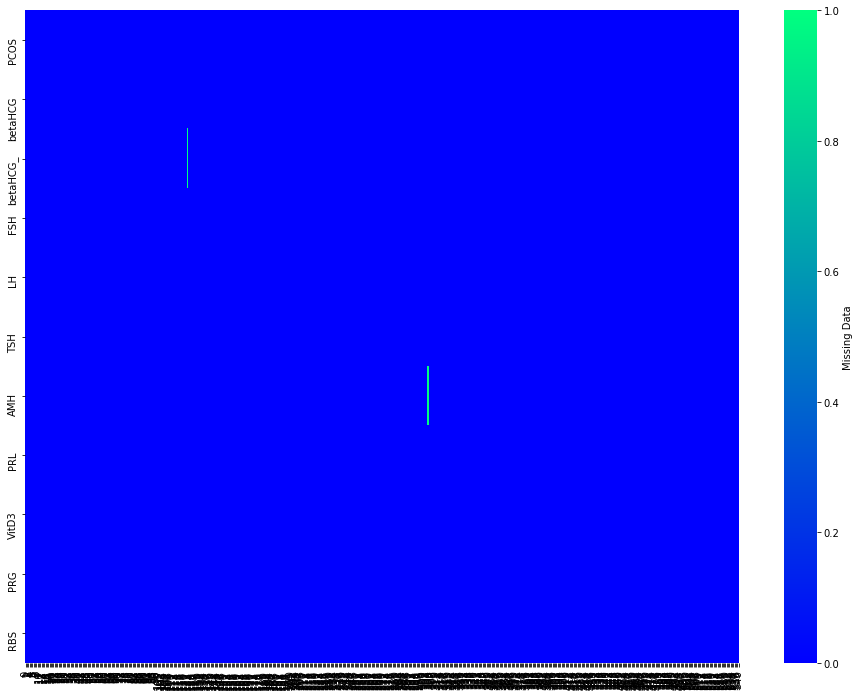

In [7]:
#plotting heatmap to visualize missing values
plt.figure(figsize=(16,12))
sns.heatmap(df.isna().transpose(),
            cmap="winter",
            cbar_kws={'label': 'Missing Data'}, xticklabels=True, yticklabels=True)

In [8]:
#column names with missing data
lst_missing_columns = df.columns[df.isna().any()].tolist()
lst_missing_columns

['betaHCG_', 'AMH']

In [9]:
#filling missing values with their median
for x in lst_missing_columns:
    df[x] = df[x].fillna(df[x].median()) #filling columns with missing value with their median

In [10]:
#Verifying if any missing values are left
df.columns[df.isna().any()].tolist() #no more missing values left

[]

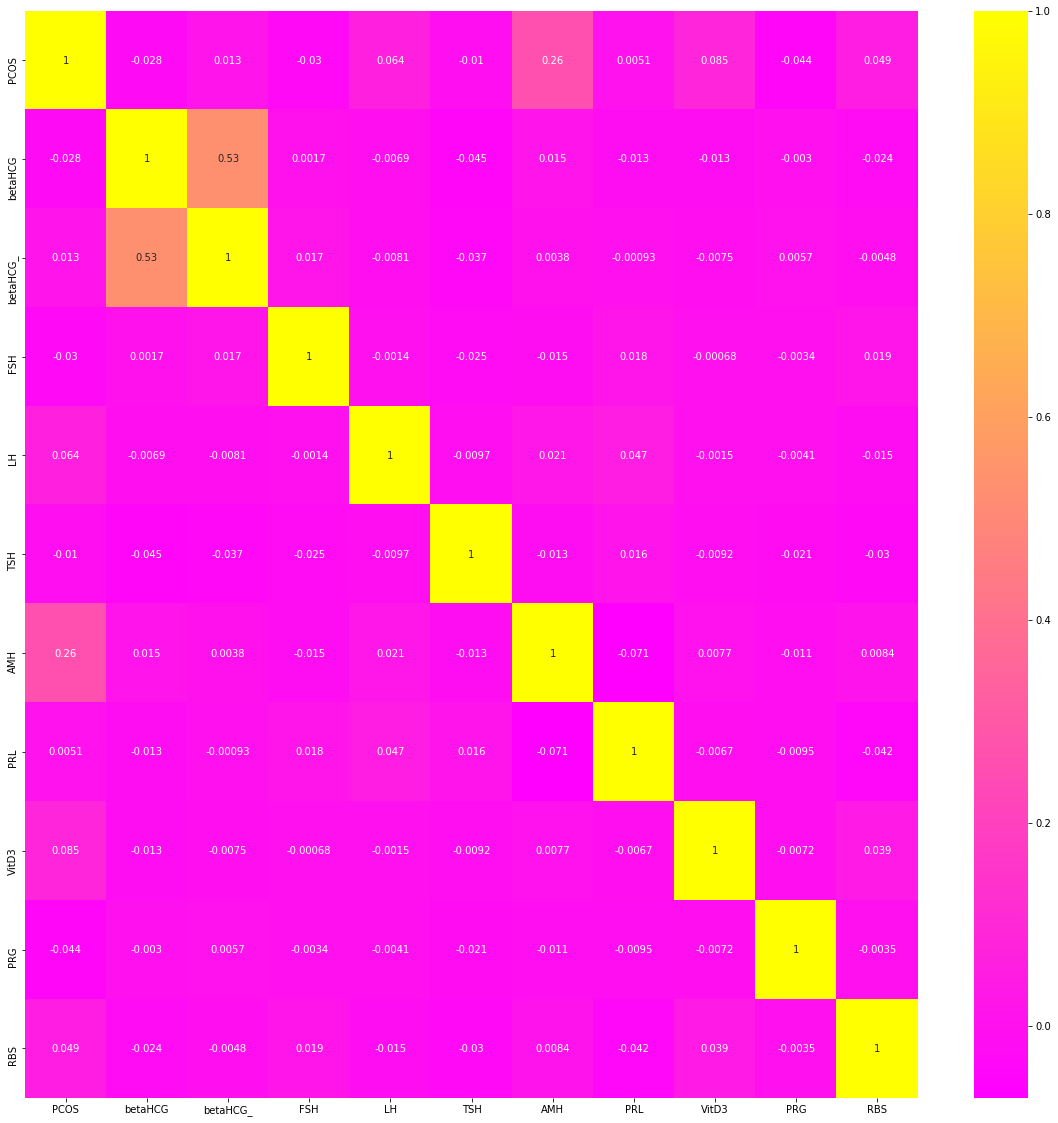

In [11]:
#Plotting correlation heatmap
plt.figure(figsize=(20, 20))
# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="spring", annot=True)
  
# displaying heatmap
plt.show()

In [12]:
#Checking how different features are correlated to PCOS
df.corr()["PCOS"].sort_values(ascending=False) #sorting in descending order

PCOS        1.000000
AMH         0.264141
VitD3       0.085494
LH          0.063879
RBS         0.048922
betaHCG_    0.012760
PRL         0.005143
TSH        -0.010140
betaHCG    -0.027617
FSH        -0.030319
PRG        -0.043834
Name: PCOS, dtype: float64

In [13]:
#Identifying numerical and categorical features in dataframe
numerical_variables = []
categorical_variables = []
for x in df.columns:
    if len(df[x].value_counts()) < 9:
        if x not in ["RR (breaths/min)", "Cycle(R/I)", "No. of aborptions", "BP _Systolic (mmHg)", "BP _Diastolic (mmHg)"]:
            categorical_variables.append(x)
    else:
        numerical_variables.append(x)

In [14]:
categorical_variables

['PCOS']

In [15]:
numerical_variables

['betaHCG',
 'betaHCG_',
 'FSH',
 'LH',
 'TSH',
 'AMH',
 'PRL',
 'VitD3',
 'PRG',
 'RBS']

In [16]:
'''
#Plotting Box plot for the numerical variables
for y in numerical_variables:
    sns.boxplot(y=y, x="PCOS", data=df)
    plt.show()'''

'\n#Plotting Box plot for the numerical variables\nfor y in numerical_variables:\n    sns.boxplot(y=y, x="PCOS", data=df)\n    plt.show()'

In [17]:
'''
#Plotting barplot for categorical variables
for x in categorical_variables:
    if x != "PCOS":
        sns.barplot(x= x, y = "PCOS", data = df)
        plt.show()'''

'\n#Plotting barplot for categorical variables\nfor x in categorical_variables:\n    if x != "PCOS":\n        sns.barplot(x= x, y = "PCOS", data = df)\n        plt.show()'

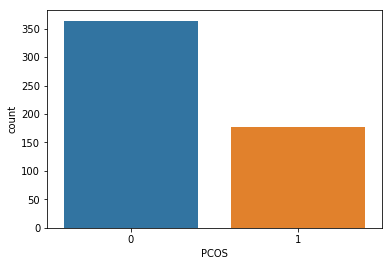

In [18]:
sns.countplot(x = "PCOS", data = df)

In [19]:
df["PCOS"].value_counts()

0    364
1    177
Name: PCOS, dtype: int64

In [20]:
177/(364 + 177)*100

32.71719038817005

In [21]:
df

,PCOS,betaHCG,betaHCG_,FSH,LH,TSH,AMH,PRL,VitD3,PRG,RBS
0,0,1.99,1.99,7.95,3.68,0.68,2.07,45.16,17.10,0.57,92.0
1,0,60.80,1.99,6.73,1.09,3.16,1.53,20.09,61.30,0.97,92.0
2,1,494.08,494.08,5.54,0.88,2.54,6.63,10.52,49.70,0.36,84.0
3,0,1.99,1.99,8.06,2.36,16.41,1.22,36.90,33.40,0.36,76.0
4,0,801.45,801.45,3.98,0.90,3.57,2.26,30.09,43.80,0.38,84.0
5,0,237.97,1.99,3.24,1.07,1.60,6.74,16.18,52.40,0.30,76.0
6,0,1.99,1.99,2.85,0.31,1.51,3.05,26.41,42.70,0.46,93.0
7,0,100.51,100.51,4.86,3.07,12.18,1.54,3.97,38.00,0.26,91.0
8,0,1.99,1.99,3.76,3.02,1.51,1.00,19.00,21.80,0.30,116.0
9,0,1.99,1.99,2.80,1.51,6.65,1.61,11.74,27.70,0.25,125.0


In [22]:
df.to_csv('PCOS_processed.csv',index=False,encoding='utf-8_sig')

In [23]:
#把RBS超过100mg/dl的数据选出来，作为研究对象（治疗干预对象）
df = df[df['RBS'] >= 100]

In [24]:
df

,PCOS,betaHCG,betaHCG_,FSH,LH,TSH,AMH,PRL,VitD3,PRG,RBS
8,0,1.990,1.99,3.76,3.02,1.510,1.00,19.00,21.800,0.30,116.0
9,0,1.990,1.99,2.80,1.51,6.650,1.61,11.74,27.700,0.25,125.0
10,0,158.510,158.51,4.89,2.02,1.560,4.47,13.47,18.100,0.36,108.0
11,0,1.990,1.99,4.09,1.47,3.980,1.67,21.10,29.180,0.25,100.0
12,1,1214.230,1214.23,2.00,1.51,6.510,7.94,22.43,31.400,0.30,125.0
14,0,1.990,1.99,7.45,3.71,1.510,0.88,19.60,24.900,0.26,116.0
15,0,1.990,1.99,9.51,2.51,1.180,0.69,92.65,9.700,0.30,116.0
17,0,1.990,1.99,4.86,2.96,5.000,1.92,12.52,26.000,0.25,100.0
18,0,1.990,1.99,6.05,1.05,3.190,1.00,12.05,23.300,0.25,127.0
19,1,23.580,1.99,1.89,0.81,2.870,2.07,19.13,28.000,0.30,100.0


In [25]:
y = df.iloc[:, 0]

In [26]:
X = df.iloc[:, 1:]

In [27]:
X

,betaHCG,betaHCG_,FSH,LH,TSH,AMH,PRL,VitD3,PRG,RBS
8,1.990,1.99,3.76,3.02,1.510,1.00,19.00,21.800,0.30,116.0
9,1.990,1.99,2.80,1.51,6.650,1.61,11.74,27.700,0.25,125.0
10,158.510,158.51,4.89,2.02,1.560,4.47,13.47,18.100,0.36,108.0
11,1.990,1.99,4.09,1.47,3.980,1.67,21.10,29.180,0.25,100.0
12,1214.230,1214.23,2.00,1.51,6.510,7.94,22.43,31.400,0.30,125.0
14,1.990,1.99,7.45,3.71,1.510,0.88,19.60,24.900,0.26,116.0
15,1.990,1.99,9.51,2.51,1.180,0.69,92.65,9.700,0.30,116.0
17,1.990,1.99,4.86,2.96,5.000,1.92,12.52,26.000,0.25,100.0
18,1.990,1.99,6.05,1.05,3.190,1.00,12.05,23.300,0.25,127.0
19,23.580,1.99,1.89,0.81,2.870,2.07,19.13,28.000,0.30,100.0


In [28]:
from pycausal.pycausal import pycausal as pc
pc = pc()
pc.start_vm()

In [29]:
from pycausal import prior as p
forbid=[['TSH','PRL'],['PRL','TSH'],['PRG','PRL'],['PRL','PRG'],['TSH','PRG'],['PRG','TSH']]
require=[['AMH','FSH'],['AMH','LH'],['RBS','FSH'],['RBS','LH'],['PRG','RBS'],['betaHCG','betaHCG_'],['betaHCG_','betaHCG']]
#tempForbid=p.ForbiddenWithin(['TSH','PRL'],['PRG','PRL']) 
temporal=[['AMH','PRG'],['betaHCG','betaHCG_','FSH','LH','TSH','AMH','PRL','VitD3']]
prior=p.knowledge(forbiddirect=forbid, requiredirect=require, addtemporal=temporal)
#prior=p.knowledge(addtemporal=temporal)
# prior=p.knowledge(requiredirect=require, addtemporal=temporal)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

1  AMH PRG
2  AMH FSH LH PRL TSH VitD3 betaHCG betaHCG_

forbiddirect
TSH PRL
PRG PRL
PRG TSH
PRL TSH

requiredirect
betaHCG betaHCG_
AMH FSH
AMH LH
PRG RBS
RBS LH
RBS FSH
betaHCG_ betaHCG

In [30]:
from pycausal import search as s
tetrad = s.tetradrunner()

In [31]:
tetrad.listAlgorithms()

fas
fask
fci
fges
fges-mb
fofc
ftfc
gfci
glasso
imgs_cont
imgs_disc
ling
lingam
mbfs
mgm
multi-fask
pc-all
r-skew
r3
rfci
rfci-bsc
skew
ts-fci
ts-gfci
ts-imgs


In [32]:
tetrad.getAlgorithmParameters(algoId='fges',scoreId='sem-bic')

faithfulnessAssumed: This is a parameter for FGES (“Fast GES”). If this is set to ‘Yes’, it will be assumed that if X _||_ Y, by an independence test, then X _||_ Y | Z for nonempty Z. If the model is faithful to the data, this will necessarily be the case. However, there are some non-faithful examples one can propose where this is not the case. If one is worried about this kind of unfaithfulness, one should set this parameter to ‘No’. If one is willing to tolerate this kind of unfaithfulness, then setting this parameter to ‘Yes’ leads to significantly faster searches. (java.lang.Boolean) [default:true]
symmetricFirstStep: For discrete searches, and in some other situations, it may make a difference for an edge X—Y whether you score X->Y or X<-Y, even though theoretically they should have the same score. If this parameter is set to “Yes”, both scores will be calculated and the higher score used. (Recall we are calculating BIC as 2L – c k ln N, where c is the penalty discount.) (java.la

In [33]:
tetrad.run(algoId='fges', dfs=X, priorKnowledge=prior, maxDegree=-1, faithfulnessAssumed=True, verbose=True)

In [34]:
ttg = tetrad.getTetradGraph()
from IPython.display import Image, display
import pydot
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [35]:
nodes = tetrad.getNodes()
edges = tetrad.getEdges()
dot_str = pc.tetradGraphToDot(ttg)
# graphs = pydot.graph_from_dot_data(dot_str)
# view_pydot(graphs[0])

In [36]:
ms = {}
ddirection = {}
for e in edges:
    ns = e.split('-->')
    ns = [s.strip() for s in ns]
    if len(ns) == 1:
        ns = e.split('---')
        ns = [s.strip() for s in ns]
        if len(ns) == 1:
            continue
        ddirection[ns[0]]=1
        ddirection[ns[1]]=1
        vs = ms.get(ns[1],[])
        if len(vs) == 0:
            ms[ns[1]] = [ns[0]]
        else:
            vs.append(ns[0])
        vs = ms.get(ns[0],[])
        if len(vs) == 0:
            ms[ns[0]] = [ns[1]]
        else:
            vs.append(ns[1])
        continue
    vs = ms.get(ns[1],[])
    if len(vs) == 0:
        ms[ns[1]] = [ns[0]]
    else:
        vs.append(ns[0])


In [37]:
coes = {}
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
for k,v in ms.items():
    lr.fit(df[v], df[k])
    coes[k] = {}
    for vname, w in zip(v,lr.coef_):
        coes[k][vname] = "{:.3f}".format(w)

In [38]:
strg = dot_str.split('\n')
for idx, sg in enumerate(strg):
    ns = sg.split('->')
    if len(ns) != 2:
        continue
    node1name = ns[0].split('"')[1]
    node2info = ns[1].split('[')
    node2name = node2info[0].split('"')[1]
    if node2info[1].find('dir=both') == -1:
        if ddirection.get(node1name,0) == 1 and ddirection.get(node2name,0) == 1:
            node2info[1]=node2info[1].replace('arrowhead=none', 'arrowhead=normal')
            strg[idx] = ' "' + node1name + '" -> "' + node2name + '" [dir=both, label=' + coes[node2name][node1name] + ',' + node2info[1]
            strg[idx] = strg[idx] + '\n' + ' "' + node2name + '" -> "' + node1name + '" [dir=both, label=' + coes[node1name][node2name] + ',' + node2info[1]
        else:
            strg[idx] = ' "' + node1name + '" -> "' + node2name + '" [label=' + coes[node2name][node1name] + ',' + node2info[1]
    else:
        strg[idx] = ' "' + node1name + '" -> "' + node2name + '" [label=' + coes[node1name][node2name] + ',' + node2info[1]


In [39]:
import os
os.environ["PATH"] += os.pathsep + 'D:\Anaconda\Lib\site-packages\graphviz'

In [40]:
dot_str = '\n'.join(strg)
from graphviz import Source
s = Source(dot_str, filename="test.gv", format="png")
s.view()

'test.gv.png'

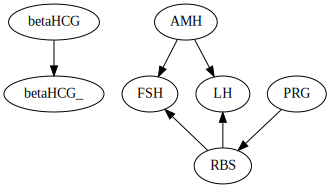

In [41]:
import pydot
from IPython.display import SVG
dot_str=pc.tetradGraphToDot(tetrad.getTetradGraph())
graphs=pydot.graph_from_dot_data(dot_str)
svg_str=graphs[0].create_svg()
SVG(svg_str)